In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

#-------------------------- set gpu using tf ---------------------------
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)

from keras.models import load_model
from keras import layers
from keras.models import Model, Input
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Importação dos dados

In [2]:
df = pd.read_csv('../fer2013/fer2013.csv', dtype={'emotion':np.int32, 'pixels':str, 'Usage':str})

In [3]:
df['pixels'] = df['pixels'].apply(lambda x: np.fromstring(x,sep=' '))

In [4]:
train = df.loc[df['Usage'] == 'Training']
validation = df.loc[df['Usage'] == 'PublicTest']
test = df.loc[df['Usage'] == 'PrivateTest']

y_train = pd.get_dummies(train['emotion'])
y_train.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

y_val = pd.get_dummies(validation['emotion'])
y_val.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

y_test = pd.get_dummies(test['emotion'])
y_test.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

In [5]:
x_train = np.vstack(train['pixels'].values)
x_validation = np.vstack(validation['pixels'].values)
x_test = np.vstack(test['pixels'].values)

In [6]:
X_train = np.stack((np.reshape(x_train,(-1, 48, 48, 1)),)*3, axis=-2).squeeze()
X_val = np.stack((np.reshape(x_validation,(-1, 48, 48, 1)),)*3, axis=-2).squeeze()
X_test =  np.stack((np.reshape(x_test,(-1, 48, 48, 1)),)*3, axis=-2).squeeze()

## Redimensionamento das imagens

In [7]:
with tf.device('/cpu:0'):
    tf_x_train = tf.placeholder(tf.float32, shape=(len(X_train), 48, 48, 3))
    tf_x_validation = tf.placeholder(tf.float32, shape=(len(X_val), 48, 48, 3))
    tf_x_test = tf.placeholder(tf.float32, shape=(len(X_test), 48, 48, 3))

    tf_x_train_resized = tf.image.resize_images(tf_x_train,  size=[75,75])
    tf_x_validation_resized = tf.image.resize_images(tf_x_validation,  size=[75,75])
    tf_x_test_resized = tf.image.resize_images(tf_x_test,  size=[75,75])

In [8]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    X_train1,X_val1,X_test1 = sess.run([tf_x_train_resized,tf_x_validation_resized,tf_x_test_resized], feed_dict={tf_x_train: X_train,
                                                   tf_x_validation: X_val,
                                                   tf_x_test: X_test
                                                  })

In [9]:
with tf.device('/cpu:0'):
    tf_x_train = tf.placeholder(tf.float32, shape=(len(X_train), 48, 48, 3))
    tf_x_validation = tf.placeholder(tf.float32, shape=(len(X_val), 48, 48, 3))
    tf_x_test = tf.placeholder(tf.float32, shape=(len(X_test), 48, 48, 3))

    tf_x_train_resized2 = tf.image.resize_images(tf_x_train,  size=[128,128])
    tf_x_validation_resized2 = tf.image.resize_images(tf_x_validation,  size=[128,128])
    tf_x_test_resized2 = tf.image.resize_images(tf_x_test,  size=[128,128])

In [10]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    X_train2,X_val2,X_test2 = sess.run([tf_x_train_resized2,tf_x_validation_resized2,tf_x_test_resized2], feed_dict={tf_x_train: X_train,
                                                   tf_x_validation: X_val,
                                                   tf_x_test: X_test
                                                  })

In [11]:
with tf.device('/cpu:0'):
    tf_x_train = tf.placeholder(tf.float32, shape=(len(X_train), 48, 48, 3))
    tf_x_validation = tf.placeholder(tf.float32, shape=(len(X_val), 48, 48, 3))
    tf_x_test = tf.placeholder(tf.float32, shape=(len(X_test), 48, 48, 3))

    tf_x_train_resized3 = tf.image.resize_images(tf_x_train,  size=[96,96])
    tf_x_validation_resized3 = tf.image.resize_images(tf_x_validation,  size=[96,96])
    tf_x_test_resized3 = tf.image.resize_images(tf_x_test,  size=[96,96])

In [12]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    X_train3,X_val3,X_test3 = sess.run([tf_x_train_resized3,tf_x_validation_resized3,tf_x_test_resized3], feed_dict={tf_x_train: X_train,
                                                   tf_x_validation: X_val,
                                                   tf_x_test: X_test
                                                  })

## Importação dos modelos

In [13]:
models_path =['./vgg16_fine_tuning.h5','./resnetv2_fine_tunning.h5','./xception_fine_tunning.h5','./mobilenet_fine_tunning.h5','./mobilenetv2_fine_tunning.h5']

In [14]:
models=[]
for model_path in models_path:

    modelTemp=load_model(model_path) # load model
    modelTemp.name=model_path # change name to be unique
    models.append(modelTemp)

## Definição de Funções Auxiliares

In [15]:
def ensembleModels(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 

    # averaging outputs
    yAvg=layers.average(yModels) 

    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

def accuracy_normalized(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_margin = np.sum(mc,axis = 1)

    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i]/mc_margin[i])

    accuracy_normalized = np.sum(tp)/n 

    return accuracy_normalized

def acuracia(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_tot = np.sum(mc)
    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i])

    accuracy = np.sum(tp)/mc_tot 

    return accuracy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Observado', fontsize=14)
    plt.xlabel('Predito', fontsize=14)
    plt.tight_layout()
    
def model_metrics(pred,y):
    pred_argmax = np.argmax(pred,axis=1)
    pred_onehot = np.zeros_like(pred)
    pred_onehot[np.arange(len(pred)), pred.argmax(1)] = 1
    y_argmax = np.argmax(np.array(y),axis=1)
    return acuracia(y_argmax,pred_argmax), accuracy_normalized(y_argmax,pred_argmax)

## Criação do Ensemble (VGG16 + Resnetv2 + Xception)

In [16]:
model_input = Input(shape=models[0].input_shape[1:])
modelEns = ensembleModels(models[:3], model_input)
modelEns.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
./vgg16_fine_tuning.h5 (Model)  (None, 7)            14729031    input_1[0][0]                    
__________________________________________________________________________________________________
./resnetv2_fine_tunning.h5 (Mod (None, 7)            54347495    input_1[0][0]                    
__________________________________________________________________________________________________
./xception_fine_tunning.h5 (Mod (None, 7)            20990511    input_1[0][0]                    
__________________________________________________________________________________________________
average_1 

## Validação da VGG16

In [17]:
pred = models[0].predict(X_val1/255.)
model_metrics(pred, y_val)

(0.6770688213987183, 0.6437437282351909)

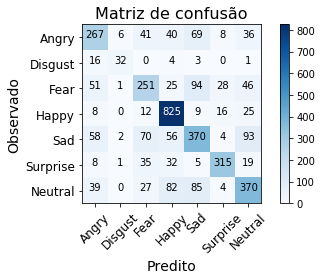

In [18]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)
plt.savefig('data_au_vgg_val.eps', format='eps', dpi=120, bbox_inches='tight', pad_inches=0)

## Teste VGG16

In [19]:
pred = models[0].predict(X_test1/255.)
model_metrics(pred, y_test)

(0.6809696294232377, 0.6553922514732514)

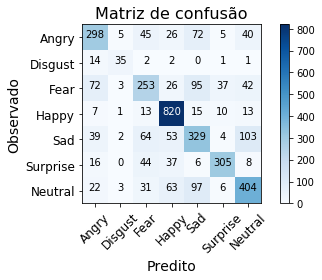

In [20]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_test.columns)

## Validação da Resnetv2

In [21]:
pred = models[1].predict(X_val1/255.)
model_metrics(pred, y_val)

(0.6617442184452493, 0.6401760345111508)

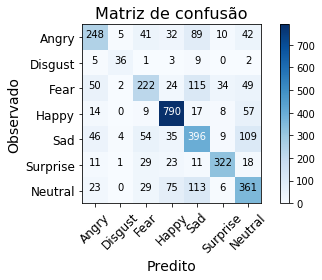

In [22]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)

## Validação da Xception

In [23]:
pred = models[2].predict(X_val1/255.)
model_metrics(pred, y_val)

(0.6614655893006408, 0.6203530683133517)

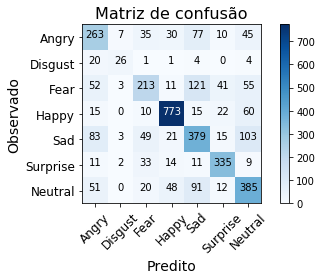

In [24]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)

## Validação da MobilenetV1

In [25]:
pred = models[3].predict(X_val2/255.)
model_metrics(pred, y_val)

(0.6517135692393424, 0.6044009657166416)

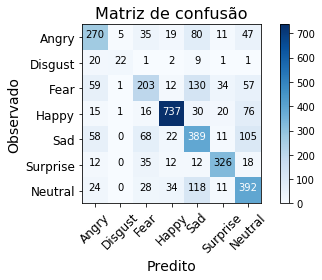

In [26]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)

## Validação da MobilenetV2

In [27]:
pred = models[4].predict(X_val3/255.)
model_metrics(pred, y_val)

(0.6258010587907495, 0.5878760409442539)

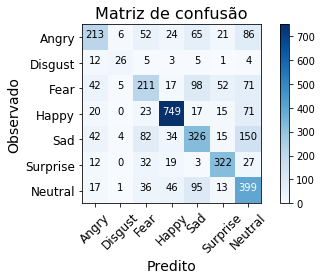

In [28]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)

## Validação do Ensemble (VGG16 + Resnetv2 + Xception)

In [29]:
pred = modelEns.predict(X_val1/255.)
model_metrics(pred, y_val)

(0.7024240735580942, 0.6687534009379122)

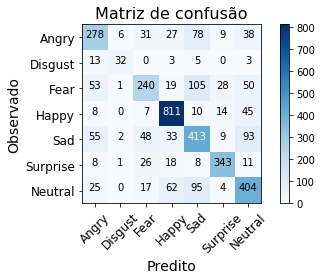

In [30]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_val.columns)
plt.savefig('data_au_ensemble_val.eps', format='eps', dpi=120, bbox_inches='tight', pad_inches=0)

## Teste do Ensemble (VGG16 + Resnetv2 + Xception)

In [31]:
pred = modelEns.predict(X_test1/255.)
model_metrics(pred, y_test)

(0.7135692393424352, 0.6881402126952062)

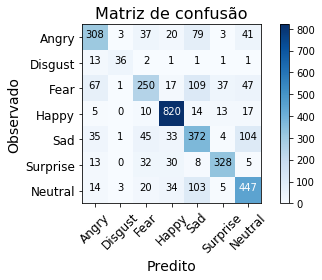

In [32]:
cnf_matrix = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(pred,axis=1))
plot_confusion_matrix(cnf_matrix, classes=y_test.columns)
plt.savefig('data_au_ensemble_teste.eps', format='eps', dpi=120, bbox_inches='tight', pad_inches=0)

In [33]:
#modelEns.save(path2ensModel)

In [34]:
#modelEns=load_model(path2ensModel)
#modelEns.summary()
#y=modelEns.predict(x)